In [0]:
from utils import *

In [0]:
from collections import OrderedDict

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import torch.nn.functional as F
import torch.optim as optim

In [0]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

In [0]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)


In [0]:
train_set = datasets.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]), download=True )

test_set = datasets.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]), download=True )


0it [00:00, ?it/s]

182042624it [00:09, 18598659.77it/s]                               
0it [00:00, ?it/s]

64282624it [00:07, 8766600.53it/s]                              


In [0]:
batch_size = 60

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                 dataset=test_set,
                 batch_size=batch_size,
                 shuffle=False)

In [0]:
class LeNet5(nn.Module):
  def __init__(self):
      super(LeNet5, self).__init__()
      self.c1    = create_maskable_module(nn.Conv2d(3, 6, kernel_size=(5, 5)))
      self.relu1 = nn.ReLU()
      self.s2    = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
      
      self.c3    = create_maskable_module(nn.Conv2d(6, 16, kernel_size=(5, 5)))
      self.relu3 = nn.ReLU()
      self.s4    = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
      
      self.c5    = create_maskable_module(nn.Conv2d(16, 120, kernel_size=(5, 5)))
      self.relu5 = nn.ReLU()
      
      self.fc = nn.Sequential(OrderedDict([
          ('f6', create_maskable_module(nn.Linear(120, 84))),
          ('relu6', nn.ReLU()),
          ('f7', create_maskable_module(nn.Linear(84, 10))),
      ]))
      
      self.init_params = self.state_dict()
      
  def forward(self, img):
      output = self.c1(img)
      output = self.relu1(output)
      output = self.s2(output)
      output = self.c3(output)
      output = self.relu3(output)
      output = self.s4(output)
      output = self.c5(output)
      output = self.relu5(output)
      
      output = output.view(img.size(0), -1)
      output = self.fc(output)

      return output
    
  def set_masks(self, masks):
      self.c1.set_mask(masks[0])
      self.c3.set_mask(masks[1])
      self.c5.set_mask(masks[2])    
      self.fc.f6.set_mask(masks[3])
      self.fc.f7.set_mask(masks[4])
      
  def reset_parameters(self):
    self.load_state_dict(self.init_params)
    
  def init_parameters(self):
    for name in self.init_params.keys():
      yield self.init_params[name]

In [42]:
%%time
net = LeNet5()

if torch.cuda.is_available():
    print('CUDA enabled.')
    net.cuda()

# Retrain
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2,
                                weight_decay=0.0001)

history = train_one_shot(net, criterion, optimizer, 
                         prepare_epochs=10, prune_epochs=10,
                         prune_percent=25, train_loader=train_loader,
                         val_loader=test_loader)

print("--- After retraining ---")
print("Accuracy: {}".format(compute_accuracy(net, test_loader)))

CUDA enabled.
Preparing: Train before prune
Training epoch 0
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Pruning...
Layer 1 | Conv layer | 5.56% parameters pruned
Layer 2 | Conv layer | 12.50% parameters pruned
Layer 3 | Conv layer | 28.27% parameters pruned
Layer 4 | Linear layer | 14.74% parameters pruned
Layer 5 | Linear layer | 7.38% parameters pruned
Current pruning rate: 24.91%
Train after prune
Training epoch 0
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
--- After retraining ---
Accuracy: 0.8697756607252612
CPU times: user 5min 49s, sys: 6.07 s, total: 5min 55s
Wall time: 5min 56s


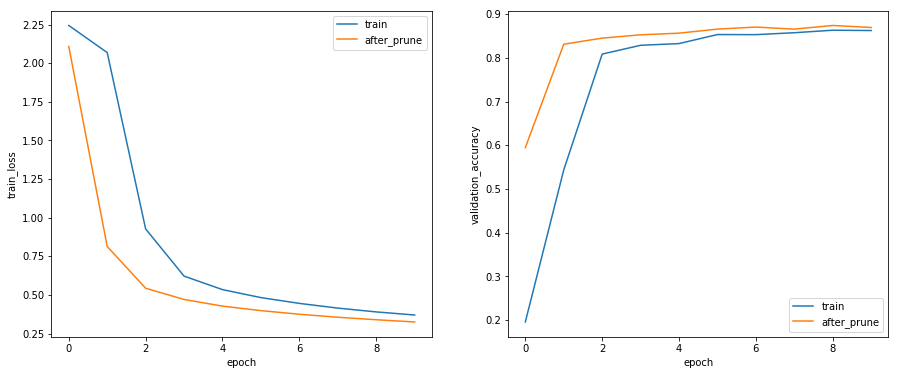

In [43]:
plt.figure(figsize=(15, 6))
for i, key in enumerate(['train_loss', 'validation_accuracy']):
  plt.subplot(1, 2, i+1)
  for stage in ['train', 'after_prune']:
    plt.plot(history[stage][key], label=stage)
  plt.ylabel(key)
  plt.xlabel('epoch')
  plt.legend()

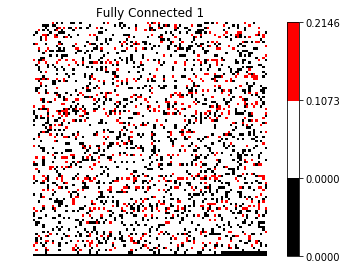

In [44]:
visualize(net.fc.f6.weight, title = "Fully Connected 1")

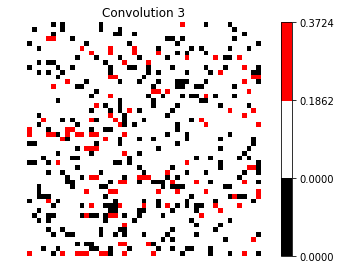

In [45]:
visualize(net.c3.weight, title = "Convolution 3")